### Import Packages

In [1]:
# Importing the required packages

import requests
from bs4 import BeautifulSoup
import json
import time
import csv
import pandas as pd

### Security Settings for web scraping

In [2]:
# Ensuring security settings to enable web scraping

housingDataDict = []
headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'max-age=0',
        'cookie': 'zguid=23|%24d14f0059-d03b-4422-9f57-5862fcd13490; _ga=GA1.2.1741285320.1590755697; zjs_user_id=null; zjs_anonymous_id=%22d14f0059-d03b-4422-9f57-5862fcd13490%22; __gads=ID=1050523ba93d593d:T=1590755700:S=ALNI_MZlJJ_xqSbd51oJisV_HY4g017Ehw; _gcl_au=1.1.2000298647.1590755705; KruxPixel=true; _fbp=fb.1.1590755705919.1815197270; _pxvid=d6c5ec75-a1a8-11ea-b8a9-0242ac120009; KruxAddition=true; JSESSIONID=3E7EBDB1F8931DF7D0DE9992546AE0B3; zgsession=1|200e23e0-9534-4d27-931f-caa3de6b483b; _gid=GA1.2.1328942480.1590858452; _gat=1; DoubleClickSession=true; GASession=true; _uetsid=fdde22d5-862a-8a7d-93e4-a16c574edf91; _pin_unauth=YzUyOGQ2OGMtMmQ3YS00NGZkLTg3MmEtOGJlODM1YWMwMTA1; _px3=026336d3721eec42bcdec3278ad2d3ac2014d5e65707b21624fb2e743d9a89be:mq3WRz2RNL5PBIvbYNHCxq5VfXHXy2YKC+8Lqn97pIw8MiKppH7Cx7AjKzbAFi1zcehKGY36aIgsnE9NiPKwlw==:1000:4U1o3ogIQ0KzfyMd2QYEFGDnD1augezy5bJlzEn9ZHE89B2uEIxDg8BmsGj8szPwyIz1Yv15S2V0TV5P+0jCFisfGk92XM4DM7K13GCtNr0HXhNGftVBFxVrCv8ApRphw/Qwj7AcagCh9i6FPiQGLFruxVASJXLsNpFeWimekVY=; AWSALB=ZKAGBcH2BwM6D1bRKOPynbOqyclySGz5U/fZB+wO3MYQ91UR9A5rFVtFsmjOkrMASUJguhtsJRZDM7IlBiWVT/pGw2S0BjxgEZmpFPrBZEqU2lWTE2NMArtecZD2; AWSALBCORS=ZKAGBcH2BwM6D1bRKOPynbOqyclySGz5U/fZB+wO3MYQ91UR9A5rFVtFsmjOkrMASUJguhtsJRZDM7IlBiWVT/pGw2S0BjxgEZmpFPrBZEqU2lWTE2NMArtecZD2; search=6|1593450465587%7Crect%3D40.843698984643765%252C-73.50417109960938%252C40.567821651427245%252C-74.45174190039063%26rid%3D6181%26disp%3Dmap%26mdm%3Dauto%26p%3D2%26z%3D0%26lt%3Dfsbo%26fs%3D1%26fr%3D0%26mmm%3D0%26rs%3D0%26ah%3D0%26singlestory%3D0%26housing-connector%3D0%26abo%3D0%26garage%3D0%26pool%3D0%26ac%3D0%26waterfront%3D0%26finished%3D0%26unfinished%3D0%26cityview%3D0%26mountainview%3D0%26parkview%3D0%26waterview%3D0%26hoadata%3D1%26zillow-owned%3D0%263dhome%3D0%09%096181%09%09%09%09%09%09',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'
    }

### Requesting the response page of each URL

In [3]:
# Function pings a website and gets the response page of the URL

# Input arguement: URL of the website
# Output: Response object of the URL

def getPage(url):
    page = requests.get(url, headers=headers) # When you ping a website or portal for information this is called making a request.
    return page

### Parsing the desired tags from the web page

In [4]:
# Function to parse all the required attributes and information from the Zillow webpage

# Input arguments: (Response object of URL, Number of records to be scraped)
# Output: Dictionary containing all the features (key) and their corresponding scraped values (value)

def parsePage(response, noOfRecords):
    htmlMain = BeautifulSoup(response, 'lxml') # lxml parser is faster and more lenient
    houseCards = htmlMain.find('ul', {'class': 'photo-cards photo-cards_wow photo-cards_short'}) # parsing every listing card
    for card in houseCards.contents:
        scriptClass = card.find('script', {'type': 'application/ld+json'})
        if scriptClass:
            scriptJson = json.loads(scriptClass.contents[0])

            #------- Beds and Bath--------------------------
            cardDetails = card.find('ul', {'class':'list-card-details'}) # tag for parsing beds & bath details
            cardDetailArr=[]
            if cardDetails:
                for cardDetail in cardDetails.find_all('li'):
                    cardDetailArr.append(cardDetail.text.split()[0])
            beds = cardDetailArr[0] if len(cardDetailArr)>0 else 0  # parse first element of card as beds
            baths = cardDetailArr[1] if len(cardDetailArr)>1 else 0 # parse second element of card as bath
            #------- Beds and Bath--------------------------

            try:
            # -------- Details page --------------------------
                housePage = getPage(scriptJson['url'])
                htmlHouse = BeautifulSoup(housePage.text, 'lxml') # parsing page for more details about each listing

                # Facts list
                houseFacts = htmlHouse.find('ul', {'class': 'ds-home-fact-list'}) # Facts & features of the house
                if houseFacts:
                    factsArr= []
                    factsCol=[]
                    for facts in houseFacts.find_all('li'):  # Parse li tags
                        factsArr.append(facts.text.split(':')[1])

                    parking      = factsArr[4].split()[0] if len(factsArr)==5 else 0 # Parking is the 4th/5th tag in the facts & features array
                    pricePerSqft = factsArr[6] if len(factsArr)==7 else 0 #5th/6th tag in Facts & features array
                
                # ---------- saves and views --------------------
                attrArr = []
                for attr in htmlHouse.find_all('div', {'class':'Text-aiai24-0 sc-qYsuA kGiUwM'}): # Parsing the "Overview" tag
                    attrArr.append(attr.text)

                timeOnZillow = attrArr[0] # extracting these 3 features from the Overview tag
                views = attrArr[1]
                saves = attrArr[2]
                
                # ---------- zestimate and rental estimate --------------------                
                homeValueHtml = htmlHouse.find('div', {'id':'ds-home-values'})
                zestimate = homeValueHtml.find('p', {'class':'Text-aiai24-0 sc-fzoxKX sc-oTpqt loFLRQ'}).text

                rentalHomeValueHtml = htmlHouse.find('div', {'id':'ds-rental-home-values'})
                rentalZestimate = rentalHomeValueHtml.find('p', {'class':'Text-aiai24-0 sc-fzoxKX sc-oTpqt loFLRQ'}).text

                # --------- School ratings ---------------
                attrArr = []
                schoolHtml = htmlHouse.find('ul', {'class':'ds-nearby-schools-list'})
                for attr in schoolHtml.find_all('span', {'class':'Text-aiai24-0 bBtYeM'}):
                    attrArr.append(attr.text)
                # ['2', 'K-3', '0.4 mi', '3', '4-8', '0.2 mi', '5', '9-12', '0.7 mi'] : output array
                ele_rating = attrArr[0] # extracting only the rating and distances (mi) of each school
                ele_dist   = attrArr[2]
                mid_rating = attrArr[3]
                mid_dist   = attrArr[5]
                high_rating = attrArr[6]
                high_dist   = attrArr[8]

            except:
                continue
                # print('Parsing error in details page, url:', scriptJson['url'])
                
                
            #-------- Final Data --------------------------
            housingDataDict.append({
                'sqft': scriptJson['floorSize']['value'],
                'url': scriptJson['url'],
                'price': card.find('div', {'class': 'list-card-price'}).text,
                'locality' : scriptJson['address']['addressLocality'],
                'postalCode' : scriptJson['address']['postalCode'],
                'type' : factsArr[0],
                'yearBuilt' : factsArr[1],
                'heating' : factsArr[2],
                'cooling' : factsArr[3],
                'parking' : parking,
                'pricePerSqft' : pricePerSqft,
                'beds' : beds,
                'baths' : baths,
                'timeOnZillow' : timeOnZillow,
                'views' : views,
                'saves' : saves,
                'zestimate' : zestimate,
                'rentalZestimate' : rentalZestimate,
                'ele_rating' : ele_rating,
                'ele_dist'   : ele_dist,
                'mid_rating' : mid_rating,
                'mid_dist'   : mid_dist,
                'high_rating' : high_rating,
                'high_dist'   : high_dist
            })
            # limit the page query to the no records
            if len(housingDataDict) >= noOfRecords:
                return

### Web Scraping - Zillow.com

In [5]:
# Function scrapes the house listing details for each city from Zillow

# Input arguments: (city- Choosing 9 cities, Number of records to be scraped for each city)

def scrapeZillow(city, noOfRecords):
    MAX_PAGES=30

    # Automating the url creation for each page of each city
    for page in range(1, MAX_PAGES):
        # https://www.zillow.com/san-jose-ca/2_p/
        url = 'https://www.zillow.com/' + city + '/' +str(page)+ '_p/'  # This is the general url format for each page

        # get the request page
        res = getPage(url)
        try:
            parsePage(res.text, noOfRecords)
        except:
            continue
            # print("Parsing error for the page, url:", url)
        
        # stop paging if the no of records is reached
        if len(housingDataDict) >= noOfRecords:
            break

        # delay every hit so that Zillow does not throw us out
        time.sleep(1)
    return page

### Writing the scraped data for all cities into a CSV file for Analysis

In [6]:
# Adding all the cities to be scraped
cities = ['san-jose-ca', 'new-york-ny', 'palo-alto-ca', 'fremont-ca', 'san-francisco-ca', 'sunny-vale-ca', 'mountain-view-ca','los-angeles-ca','dallas-tx']
noOfRecords = 10 #Using 10 for display purpose. Change to 100 to scrape 100 records for each city
combined_file_name = "group_1_zillow_data_1.csv"

combined_df = pd.DataFrame() # single dataframe to store details of all the cities

# Start scraping
for city in cities:
    housingDataDict = [] # list stores the final scraped data for each city
    pages = scrapeZillow(city, noOfRecords) # calling scrapeZillow() function

    # Save the data for current city
    df = pd.DataFrame(housingDataDict)  
    if len(df.index) > 0 :
        fileName = city + '.csv'   # writing every city details into a .csv file
        df.to_csv(fileName, index=False) 
        df['original_city'] = list([city]*len(df.index))  # adding this column to contain city name
        if combined_df.empty:
            combined_df = df
        else:
            combined_df = pd.concat([combined_df, df])                                                                                                  
        print('No of pages scraped to get {0} records for {1} is {2}'.format(noOfRecords, city, pages))
    else:
        print("Could not retrive any pages for {}. Tried scrapping {} pages ". format(city, pages))         

    # display
    print('5 sample Records below:')
    display(df.head(5))

No of pages scraped to get 10 records for san-jose-ca is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,"2,988",https://www.zillow.com/homedetails/3420-Myersl...,"$1,580,000",San Jose,95148,Single Family,1988,Forced air,Central,0,...,168,"$1,584,716","$4,500/mo",7,0.5 mi,7,0.5 mi,9,0.4 mi,san-jose-ca
1,"1,720",https://www.zillow.com/homedetails/6163-Cottle...,"$875,000",San Jose,95123,Single Family,1972,"Forced air, Gas",Central,0,...,334,"$932,424","$3,700/mo",6,0.4 mi,6,1 mi,8,1.5 mi,san-jose-ca
2,"1,647",https://www.zillow.com/homedetails/1656-Fern-P...,"$899,000",San Jose,95131,Single Family,1985,Forced air,Central,0,...,123,"$944,894","$3,600/mo",8,0.5 mi,6,2.4 mi,6,1 mi,san-jose-ca
3,"2,084",https://www.zillow.com/homedetails/369-Avenida...,"$1,049,000",San Jose,95123,Single Family,1971,"Forced air, Gas",Central,0,...,145,"$1,149,573","$3,500/mo",4,0.1 mi,7,1.1 mi,8,1.5 mi,san-jose-ca
4,"1,405",https://www.zillow.com/homedetails/1024-De-Mat...,"$928,800",San Jose,95112,Single Family,1977,Forced air,Central,0,...,100,"$972,838","$3,500/mo",3,2.1 mi,3,1.4 mi,3,0.8 mi,san-jose-ca


No of pages scraped to get 10 records for new-york-ny is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,"1,050",https://www.zillow.com/homedetails/100-W-57th-...,"$295,000",New York,10019,Condo,1962,No Data,Central,0,...,"1,480","$933,098","$3,500/mo",10,0.3 mi,9,1.7 mi,9,2.3 mi,new-york-ny
1,"20,000",https://www.zillow.com/homedetails/12-E-69th-S...,"$79,000,000",New York,10021,Single Family,1910,No Data,Central,0,...,636,"$19,942,056","$65,000/mo",10,0.5 mi,2,1.6 mi,9,2.8 mi,new-york-ny
2,950,https://www.zillow.com/homedetails/100-W-57th-...,"$299,000",New York,10019,Condo,1962,No Data,Central,0,...,515,"$481,610","$2,500/mo",10,0.3 mi,9,1.7 mi,9,2.3 mi,new-york-ny
3,None,https://www.zillow.com/homedetails/415-Central...,"$299,500",New York,10025,Condo,1926,No Data,No Data,0,...,608,"$667,279","$3,700/mo",7,0.4 mi,6,0.5 mi,1,0.3 mi,new-york-ny
4,"13,000",https://www.zillow.com/homedetails/12-E-63rd-S...,"$67,000,000",New York,10065,Townhouse,1910,No Data,Central,0,...,660,"$16,537,475","$170,746/mo",10,0.4 mi,2,1.9 mi,9,2.5 mi,new-york-ny


No of pages scraped to get 10 records for palo-alto-ca is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,"12,657",https://www.zillow.com/homedetails/610-Los-Tra...,"$53,888,000",Palo Alto,94304,Single Family,2008,Forced air,Central,0,...,261,"$11,998,942","$35,451/mo",8,3.9 mi,7,5 mi,9,4.6 mi,palo-alto-ca
1,"1,874",https://www.zillow.com/homedetails/3757-Cass-W...,"$2,288,000",Palo Alto,94306,Single Family,1959,"Forced air, Gas",Central,0,...,50,"$2,383,382","$6,495/mo",8,0.2 mi,7,0.9 mi,9,0.8 mi,palo-alto-ca
2,"2,355",https://www.zillow.com/homedetails/570-Kelly-W...,"$2,798,000",Palo Alto,94306,Single Family,1950,"Forced air, Gas",Central,0,...,68,"$2,957,885","$7,500/mo",8,0.4 mi,7,0.4 mi,9,0.7 mi,palo-alto-ca
3,"3,575",https://www.zillow.com/homedetails/2938-Ross-R...,"$4,988,000",Palo Alto,94303,Single Family,2019,"Forced air, Gas",Central,0,...,18,"$5,159,999","$5,900/mo",9,0.6 mi,9,0.8 mi,9,2.1 mi,palo-alto-ca
4,"2,640",https://www.zillow.com/homedetails/1007-N-Cali...,"$3,895,000",Palo Alto,94303,Single Family,2017,"Forced air, Gas",Central,0,...,20,"$3,915,473","$8,647/mo",9,0.4 mi,7,0.5 mi,9,1.8 mi,palo-alto-ca


No of pages scraped to get 10 records for fremont-ca is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,"1,531",https://www.zillow.com/homedetails/40172-Miche...,"$975,000",Fremont,94538,Single Family,1958,"Electric, Gas",Wall,0,...,32,"$1,008,990","$3,200/mo",8,0.1 mi,7,1.2 mi,7,1.5 mi,fremont-ca
1,"1,648",https://www.zillow.com/homedetails/253-Anza-St...,"$900,000",Fremont,94539,Single Family,2012,No Data,No Data,0,...,210,"$1,348,791","$3,500/mo",9,0.1 mi,9,1.7 mi,10,1.2 mi,fremont-ca
2,"1,323",https://www.zillow.com/homedetails/243-D-St-Fr...,"$999,998",Fremont,94536,Single Family,1952,"Forced air, Gas",None,0,...,172,"$1,027,270","$3,200/mo",8,0.2 mi,7,1.6 mi,8,1.6 mi,fremont-ca
3,"1,382",https://www.zillow.com/homedetails/49002-Cinna...,"$430,647",Fremont,94539,Condo,2009,Electric,Central,0,...,398,"$434,895","$3,200/mo",10,1.7 mi,8,5.2 mi,9,5.1 mi,fremont-ca
4,"2,297",https://www.zillow.com/homedetails/4495-Burke-...,"$1,249,000",Fremont,94536,Single Family,1959,"Forced air, Gas",Central,0,...,80,"$1,297,038","$3,500/mo",8,0.1 mi,7,0.8 mi,8,0.5 mi,fremont-ca


No of pages scraped to get 10 records for san-francisco-ca is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,"10,725",https://www.zillow.com/homedetails/190-Sea-Cli...,"$25,000,000",San Francisco,94121,Single Family,1913,"Forced air, Gas",Central,0,...,"1,116","$11,425,617","$17,500/mo",8,0.5 mi,8,0.5 mi,7,0.7 mi,san-francisco-ca
1,"11,635",https://www.zillow.com/homedetails/2799-Broadw...,"$37,000,000",San Francisco,94115,Single Family,No Data,Gas,No Data,0,...,615,"$36,041,452","$24,531/mo",2,0.4 mi,9,1.2 mi,6,0.7 mi,san-francisco-ca
2,"1,196",https://www.zillow.com/homedetails/248-Lauren-...,"$368,008",San Francisco,94134,Condo,2008,Forced air,Central,0,...,409,"$368,009","$3,200/mo",2,0.6 mi,5,0.3 mi,5,0.7 mi,san-francisco-ca
3,"1,166",https://www.zillow.com/homedetails/2335-30th-A...,"$1,095,000",San Francisco,94116,Single Family,1926,"Forced air, Gas",Central,0,...,384,"$1,398,215","$4,250/mo",8,0.4 mi,9,0.7 mi,7,0.5 mi,san-francisco-ca
4,"1,802",https://www.zillow.com/homedetails/955-Innes-A...,"$699,950",San Francisco,94124,Single Family,1956,Gas,No Data,0,...,31,"$1,115,039","$4,200/mo",4,0.3 mi,2,1.4 mi,7,0.3 mi,san-francisco-ca


No of pages scraped to get 10 records for sunny-vale-ca is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,999,https://www.zillow.com/homedetails/644-Johanna...,"$798,000",Sunnyvale,94085,Single Family,1953,None,None,0,...,99,"$828,044","$3,300/mo",5,0.3 mi,3,0.5 mi,8,2.6 mi,sunny-vale-ca
1,"1,406",https://www.zillow.com/homedetails/602-Cypress...,"$1,300,000",Sunnyvale,94085,Single Family,1954,"Forced air, Gas",Wall,0,...,28,"$1,388,339","$3,600/mo",5,0.4 mi,3,0.4 mi,8,2.4 mi,sunny-vale-ca
2,"1,966",https://www.zillow.com/homedetails/1062-Grape-...,"$2,249,888",Sunnyvale,94087,Single Family,1953,Forced air,Central,0,...,20,"$2,396,996","$5,000/mo",9,0.3 mi,6,0.2 mi,8,1.6 mi,sunny-vale-ca
3,"1,510",https://www.zillow.com/homedetails/1526-Gambie...,"$1,988,000",Sunnyvale,94087,Single Family,1959,"Forced air, Gas",Central,0,...,43,"$2,187,910","$4,592/mo",9,0.5 mi,8,0.4 mi,8,0.5 mi,sunny-vale-ca
4,"1,837",https://www.zillow.com/homedetails/1586-Magpie...,"$2,188,000",Sunnyvale,94087,Single Family,1961,"Forced air, Gas",Central,0,...,18,"$2,396,495","$4,599/mo",8,0.8 mi,8,2.7 mi,8,1.3 mi,sunny-vale-ca


No of pages scraped to get 10 records for mountain-view-ca is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,"1,375",https://www.zillow.com/homedetails/114-Magnoli...,"$1,498,000",Mountain View,94043,Single Family,1998,"Forced air, Gas",Central,0,...,51,"$1,511,805","$4,000/mo",8,0.7 mi,6,2 mi,8,1.9 mi,mountain-view-ca
1,"1,839",https://www.zillow.com/homedetails/113-Estrada...,"$1,998,000",Mountain View,94043,Single Family,1997,"Forced air, Gas",Central,0,...,27,"$2,052,739","$5,000/mo",8,0.6 mi,6,1.9 mi,8,1.9 mi,mountain-view-ca
2,"2,276",https://www.zillow.com/homedetails/1015-Katrin...,"$2,388,000",Mountain View,94040,Single Family,1966,"Forced air, Gas",No Data,0,...,29,"$2,544,138","$6,190/mo",8,0.8 mi,6,1.6 mi,8,0.3 mi,mountain-view-ca
3,"1,782",https://www.zillow.com/homedetails/404-Baywood...,"$1,698,000",Alviso,94040,Condo,1988,"Forced air, Gas",Central,0,...,6,"$1,752,444","$3,400/mo",5,0.7 mi,6,1.6 mi,9,1 mi,mountain-view-ca
4,"1,292",https://www.zillow.com/homedetails/255-S-Rengs...,"$1,095,000",Mountain View,94040,Single Family,1965,"Forced air, Gas",Central,0,...,52,"$1,098,424","$3,778/mo",5,0.3 mi,6,1.3 mi,9,1.1 mi,mountain-view-ca


No of pages scraped to get 10 records for los-angeles-ca is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,758,https://www.zillow.com/homedetails/18645-Hatte...,"$340,900",Los Angeles,91356,Condo,1973,"Forced air, Electric",Central,0,...,163,"$324,429","$1,950/mo",3,0.4 mi,6,0.7 mi,5,1 mi,los-angeles-ca
1,"30,000",https://www.zillow.com/homedetails/10979-Chalo...,"$67,500,000",Los Angeles,90077,Single Family,2018,"Forced air, Gas",Central,0,...,"3,548","$38,124,774","$69,958/mo",9,2.2 mi,5,2.4 mi,6,2.4 mi,los-angeles-ca
2,"10,500",https://www.zillow.com/homedetails/4379-Firmam...,"$9,500,000",Encino,91436,Single Family,2019,Forced air,Central,0,...,"1,452","$8,293,933","$28,583/mo",8,1.3 mi,5,3.3 mi,6,3 mi,los-angeles-ca
3,"38,000",https://www.zillow.com/homedetails/2571-Wallin...,"$85,000,000",Beverly Hills,90210,Single Family,2000,"None, Forced air",Other,0,...,"2,124","$39,882,000","$118,643/mo",8,3.1 mi,5,4 mi,6,4.9 mi,los-angeles-ca
4,"1,351",https://www.zillow.com/homedetails/2045-Beloit...,"$843,900",Los Angeles,90025,Condo,1989,"None, Forced air",Central,0,...,130,"$846,009","$3,750/mo",7,0.4 mi,3,0.8 mi,6,1.2 mi,los-angeles-ca


No of pages scraped to get 10 records for dallas-tx is 1
5 sample Records below:


,sqft,url,price,locality,postalCode,type,yearBuilt,heating,cooling,parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,"15,043",https://www.zillow.com/homedetails/10660-Strai...,"$14,500,000",Dallas,75229,Single Family,2001,"Forced air, Gas",Central,0,...,"1,375","$13,163,450","$65,071/mo",7,1.6 mi,4,1.9 mi,3,1.6 mi,dallas-tx
1,"1,818",https://www.zillow.com/homedetails/8017-Clarem...,"$344,900",Dallas,75228,Single Family,1958,"Forced air, Gas",Central,0,...,974,"$342,332","$1,945/mo",2,0.2 mi,4,1.9 mi,4,2.5 mi,dallas-tx
2,"1,268",https://www.zillow.com/homedetails/4408-Lawnvi...,"$175,000",Dallas,75227,Single Family,1946,"Forced air, Gas",Wall,0,...,654,"$173,128","$1,285/mo",3,0.9 mi,3,2.4 mi,2,1.9 mi,dallas-tx
3,"1,220",https://www.zillow.com/homedetails/2207-Nantuc...,"$165,000",Dallas,75227,Single Family,1983,Forced air,Central,0,...,172,"$66,320","$1,295/mo",5,0.9 mi,3,0.6 mi,2,1.5 mi,dallas-tx
4,"2,468",https://www.zillow.com/homedetails/2404-Sue-St...,"$225,000",Dallas,75203,Single Family,1963,"Forced air, Gas",Central,0,...,"1,312","$224,533","$1,700/mo",5,1.1 mi,2,1 mi,2,0.7 mi,dallas-tx


In [7]:
# Export all the data to a single csv file
if not combined_df.empty:                                              
    combined_df.to_csv(combined_file_name, index=False, encoding='utf-8-sig') # final CSV that stores all city details
    print('Successfully saved file')
else:
    print("Could not scrape any data") 

Successfully saved file


# DATA CLEANING

## Import Libraries

In [1]:
import urllib.request 
import urllib.parse
import urllib.error
import ssl
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as BS
import re
import pandas as pd
import numpy as np
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

## Data Loading

Read the csv file which is scraped from the above.

In [2]:
df1 = pd.read_csv("group_1_zillow_data_1.csv")

## Data Exploration

In [3]:
df1.head()

,sqft,url,price,locality,postalCode,Type,Year built,Heating,Cooling,Parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,"1,105",https://www.zillow.com/homedetails/5462-Maylan...,"$798,000",San Jose,95138,Single Family,1979,"Forced air, Gas",None,0,...,92,"$839,041","$3,300/mo",6,1.3 mi,6,1.9 mi,6,1.5 mi,san-jose-ca
1,"1,546",https://www.zillow.com/homedetails/251-Omira-D...,"$949,000",San Jose,95123,Single Family,1963,"Forced air, Gas",Central,0,...,87,"$991,555","$3,600/mo",4,0.3 mi,6,2.2 mi,6,0.2 mi,san-jose-ca
2,"1,800",https://www.zillow.com/homedetails/242-Cheris-...,"$879,900",San Jose,95123,Single Family,1978,"Forced air, Gas",Central,0,...,106,"$919,640","$3,600/mo",4,0.5 mi,8,1.3 mi,6,0.6 mi,san-jose-ca
3,"1,088",https://www.zillow.com/homedetails/2801-El-Mon...,"$750,000",San Jose,95127,Single Family,1972,"Forced air, Gas",Central,0,...,102,"$777,777","$3,000/mo",3,0.5 mi,4,0.2 mi,5,0.7 mi,san-jose-ca
4,"1,354",https://www.zillow.com/homedetails/5510-Woodhu...,"$899,000",San Jose,95123,Single Family,1962,"Forced air, Gas",Central,0,...,222,"$959,573","$3,600/mo",5,1.1 mi,6,2.5 mi,4,0.4 mi,san-jose-ca


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sqft             879 non-null    object
 1   url              900 non-null    object
 2   price            900 non-null    object
 3   locality         900 non-null    object
 4   postalCode       900 non-null    int64 
 5   Type             900 non-null    object
 6   Year built       900 non-null    object
 7   Heating          900 non-null    object
 8   Cooling          900 non-null    object
 9   Parking          900 non-null    object
 10  Price/sqft       900 non-null    object
 11  beds             900 non-null    object
 12  baths            900 non-null    object
 13  timeOnZillow     900 non-null    object
 14  views            900 non-null    object
 15  saves            900 non-null    object
 16  zestimate        900 non-null    object
 17  rentalZestimate  900 non-null    ob

We scraped data of 900 rows and 25 columns. Almost all the variables are in 'object' datatype.

In [5]:
clean_df = df1.copy()
clean_df.columns

Index(['sqft', 'url', 'price', 'locality', 'postalCode', 'Type', 'Year built',
       'Heating', 'Cooling', 'Parking', 'Price/sqft', 'beds', 'baths',
       'timeOnZillow', 'views', 'saves', 'zestimate', 'rentalZestimate',
       'ele_rating', 'ele_dist', 'mid_rating', 'mid_dist', 'high_rating',
       'high_dist', 'original_city'],
      dtype='object')

## Removing Regular Expressions

Scraped data has unreadable characters and spaces. Firstly we removed such impurities.

In [6]:
for i in ['Year built','Parking', 'sqft', 'price', 'Price/sqft', 'views', 'saves', 'zestimate', 'rentalZestimate', 
         'ele_dist', 'mid_dist', 'high_dist','timeOnZillow']:
    clean_df[i] = clean_df[i].replace(regex='[--]',value='')
    clean_df[i] = clean_df[i].replace(regex='[,$/A-Za-z]',value='')
    clean_df[i] = clean_df[i].str.lstrip('.')    
    clean_df[i] = clean_df[i].replace(regex='[ ]',value='')
    clean_df[i] = clean_df[i].replace(regex='[+]',value='')

clean_df

,sqft,url,price,locality,postalCode,Type,Year built,Heating,Cooling,Parking,...,saves,zestimate,rentalZestimate,ele_rating,ele_dist,mid_rating,mid_dist,high_rating,high_dist,original_city
0,1105,https://www.zillow.com/homedetails/5462-Maylan...,798000,San Jose,95138,Single Family,1979,"Forced air, Gas",None,0,...,92,839041,3300,6,1.3,6,1.9,6,1.5,san-jose-ca
1,1546,https://www.zillow.com/homedetails/251-Omira-D...,949000,San Jose,95123,Single Family,1963,"Forced air, Gas",Central,0,...,87,991555,3600,4,0.3,6,2.2,6,0.2,san-jose-ca
2,1800,https://www.zillow.com/homedetails/242-Cheris-...,879900,San Jose,95123,Single Family,1978,"Forced air, Gas",Central,0,...,106,919640,3600,4,0.5,8,1.3,6,0.6,san-jose-ca
3,1088,https://www.zillow.com/homedetails/2801-El-Mon...,750000,San Jose,95127,Single Family,1972,"Forced air, Gas",Central,0,...,102,777777,3000,3,0.5,4,0.2,5,0.7,san-jose-ca
4,1354,https://www.zillow.com/homedetails/5510-Woodhu...,899000,San Jose,95123,Single Family,1962,"Forced air, Gas",Central,0,...,222,959573,3600,5,1.1,6,2.5,4,0.4,san-jose-ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,14795,https://www.zillow.com/homedetails/6645-Northa...,6499000,Dallas,75230,Single Family,2007,"Forced air, Gas",Central,0,...,392,5981533,36979,6,1.5,5,1.1,4,1.3,dallas-tx
896,3482,https://www.zillow.com/homedetails/6938-Northa...,,Dallas,75230,Single Family,1955,Other,Central,0,...,136,5981533,36979,6,1.5,5,1.1,4,1.3,dallas-tx
897,1748,https://www.zillow.com/homedetails/5041-Linnet...,530000,Dallas,75209,Single Family,1947,"Forced air, Gas",Central,0,...,51,530004,2403,5,0.4,3,2.9,3,2.7,dallas-tx
898,3167,https://www.zillow.com/homedetails/7707-Roundr...,558500,Dallas,75248,Single Family,1965,"Forced air, Gas",Central,0,...,21,558503,2500,10,0.1,7,0.3,7,0.8,dallas-tx


## Drop rows in timeOnZillow column and strip 'days'

Dropped rows which has 'hour' values in the timeOnZillow column

In [8]:
clean_df.drop(clean_df[clean_df.timeOnZillow.str.contains('hours',case=False)].index, inplace = True)
clean_df.drop(clean_df[clean_df.timeOnZillow.str.contains('hour',case=False)].index, inplace = True)

Strip the string 'days' for the values in timeOnZillow column

In [10]:
clean_df['timeOnZillow'] = clean_df['timeOnZillow'].str.rstrip('days')

## Converting to Numeric Datatype

Converted variables to true numeric columns to perform aggregations on such columns

In [11]:
clean_df['sqft'] = pd.to_numeric(clean_df['sqft'])
clean_df['price'] = pd.to_numeric(clean_df['price'])
clean_df['Year built'] = pd.to_numeric(clean_df['Year built'])
clean_df['Price/sqft'] = pd.to_numeric(clean_df['Price/sqft'])
clean_df['views'] = pd.to_numeric(clean_df['views'])
clean_df['saves'] = pd.to_numeric(clean_df['saves'])
clean_df['zestimate'] = pd.to_numeric(clean_df['zestimate'])
clean_df['rentalZestimate'] = pd.to_numeric(clean_df['rentalZestimate'])
clean_df['ele_dist'] = pd.to_numeric(clean_df['ele_dist'])
clean_df['mid_dist'] = pd.to_numeric(clean_df['mid_dist'])
clean_df['high_dist'] = pd.to_numeric(clean_df['high_dist'])
clean_df['timeOnZillow'] = pd.to_numeric(clean_df['timeOnZillow'])

## Drop rows which has invalid 'beds', 'baths' values

There are some invalid values in the beds and baths columns.'beds' has 10.51 as the number of bedrooms which is not valid and 2.1 as the number of baths which is also not valid

In [12]:
clean_df.drop(clean_df[clean_df['beds'].isin(['10.51','0.33','30.3','0.54'])].index, inplace= True)
clean_df.drop(clean_df[clean_df['baths'].isin(['2.1','4.1'])].index, inplace= True)

## Missing Values

We found Heating, Cooling, bathh columns has null values in the form of ' -- , 0, 0.0, No Data'. Replacing these values with nothing. Thus this turns into NA's

In [13]:
clean_df['Heating'].replace({'--': None,'0':None,'0.0':None,'No Data':None},inplace =True)
clean_df['Cooling'].replace({'--': None,'0':None,'0.0':None,'No Data':None},inplace =True)
clean_df['baths'].replace({'--': None,'No Data':None,'None':None},inplace =True)

After replacing above column values. Below are the total missing values for our dataset

In [14]:
clean_df.isna().sum()

sqft                19
url                  0
price                2
locality             0
postalCode           0
Type                 0
Year built          26
Heating            137
Cooling            155
Parking              0
Price/sqft           0
beds                 0
baths               12
timeOnZillow         2
views                2
saves                2
zestimate            0
rentalZestimate      0
ele_rating           0
ele_dist             0
mid_rating           0
mid_dist             0
high_rating          0
high_dist            0
original_city        0
dtype: int64

## Impute missing values

Imputed missing values of Heating, Cooling, baths columns with mode

In [15]:
for column in clean_df[['Heating', 'Cooling','baths']]:
    clean_df[column].fillna(clean_df[column].mode()[0], inplace = True)

Imputed missing values of 'sqft' column with grouped mean of beds, baths

In [16]:
clean_df['sqft'] = clean_df.groupby(['beds','baths'])['sqft'].transform(
    lambda x: x.fillna(np.mean(x))
)

Dropped remaining rows which has null values:

In [19]:
clean_df = clean_df[clean_df['Year built'].notna()]
clean_df = clean_df[clean_df['sqft'].notna()]
clean_df = clean_df[clean_df['price'].notna()]
clean_df = clean_df[clean_df['views'].notna()]
clean_df = clean_df[clean_df['saves'].notna()]
clean_df = clean_df[clean_df['timeOnZillow'].notna()]

In [20]:
clean_df.isna().sum()

sqft               0
url                0
price              0
locality           0
postalCode         0
Type               0
Year built         0
Heating            0
Cooling            0
Parking            0
Price/sqft         0
beds               0
baths              0
timeOnZillow       0
views              0
saves              0
zestimate          0
rentalZestimate    0
ele_rating         0
ele_dist           0
mid_rating         0
mid_dist           0
high_rating        0
high_dist          0
original_city      0
dtype: int64

## Data Type Conversion

Before cleaning, these are the data types of the variables. Almost all are scraped as 'Object' type. So then we converted each of these columns to True numeric columns. We wanted few columns to be in int Datatype like Year built, views, saves, sqft. These columns are in float type so converted them into int type

In [21]:
clean_df['Year built'] = clean_df['Year built'].astype(int)
clean_df['views'] = clean_df['views'].astype(int)
clean_df['saves'] = clean_df['saves'].astype(int)
clean_df['sqft'] = clean_df['sqft'].astype(int)

In [22]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 855 entries, 0 to 899
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             855 non-null    int64  
 1   url              855 non-null    object 
 2   price            855 non-null    float64
 3   locality         855 non-null    object 
 4   postalCode       855 non-null    int64  
 5   Type             855 non-null    object 
 6   Year built       855 non-null    int64  
 7   Heating          855 non-null    object 
 8   Cooling          855 non-null    object 
 9   Parking          855 non-null    object 
 10  Price/sqft       855 non-null    int64  
 11  beds             855 non-null    object 
 12  baths            855 non-null    object 
 13  timeOnZillow     855 non-null    float64
 14  views            855 non-null    int64  
 15  saves            855 non-null    int64  
 16  zestimate        855 non-null    int64  
 17  rentalZestimate 

## Outliers

There are some datapoints which are far away from the rest of the datapoints. After observing carefully, we dont feel that these are not outliers.

Let us take first plot, price and sqft column, the point which is far away from the rest is the property in Berkeley which has some around 23 bed 20 bath, as we all know that Beverly hills is one of the expensive city among all other cities in Bay Area, we can consider it not to be an outlier. The other point here is the property in New york which is built in 1910. Though it has large square feet, as this is old construction, demand is low. So the price is low

We found multiple outliers in our dataset for different other variables but when we compared with the other factors, given the market condition, we considered them as genuine records

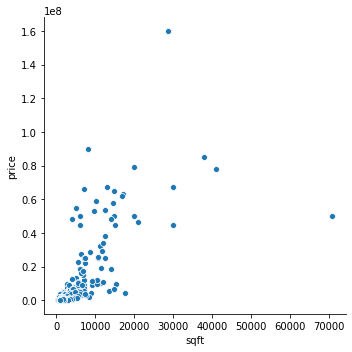

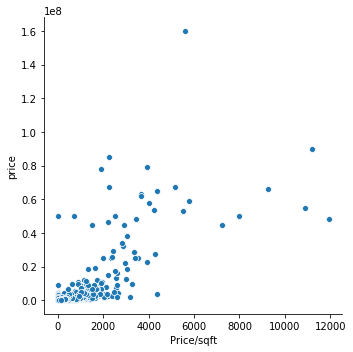

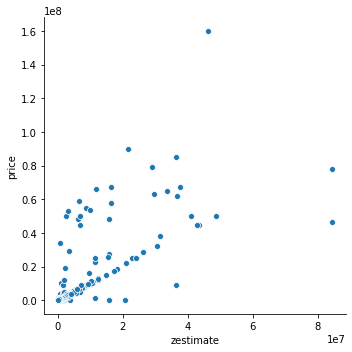

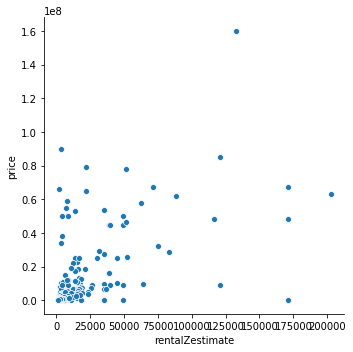

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.relplot(data=clean_df, x="sqft", y="price")
sns.relplot(data=clean_df, x="Price/sqft", y="price")
sns.relplot(data=clean_df, x="zestimate", y="price")
sns.relplot(data=clean_df, x="rentalZestimate", y="price")

Below are the boxplots for the beds,baths column

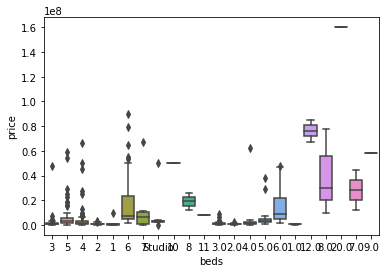

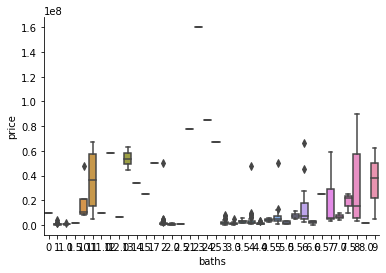

In [24]:
sns.boxplot(data=clean_df, x="beds", y="price")
plt.show()
sns.boxplot(data=clean_df, x="baths", y="price")
sns.despine()

Below is the pair plot to explore numerical variables with respect to the locality. We can check for outliers. We considered all of them as genuine records

/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/User

/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila

/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/sharmila

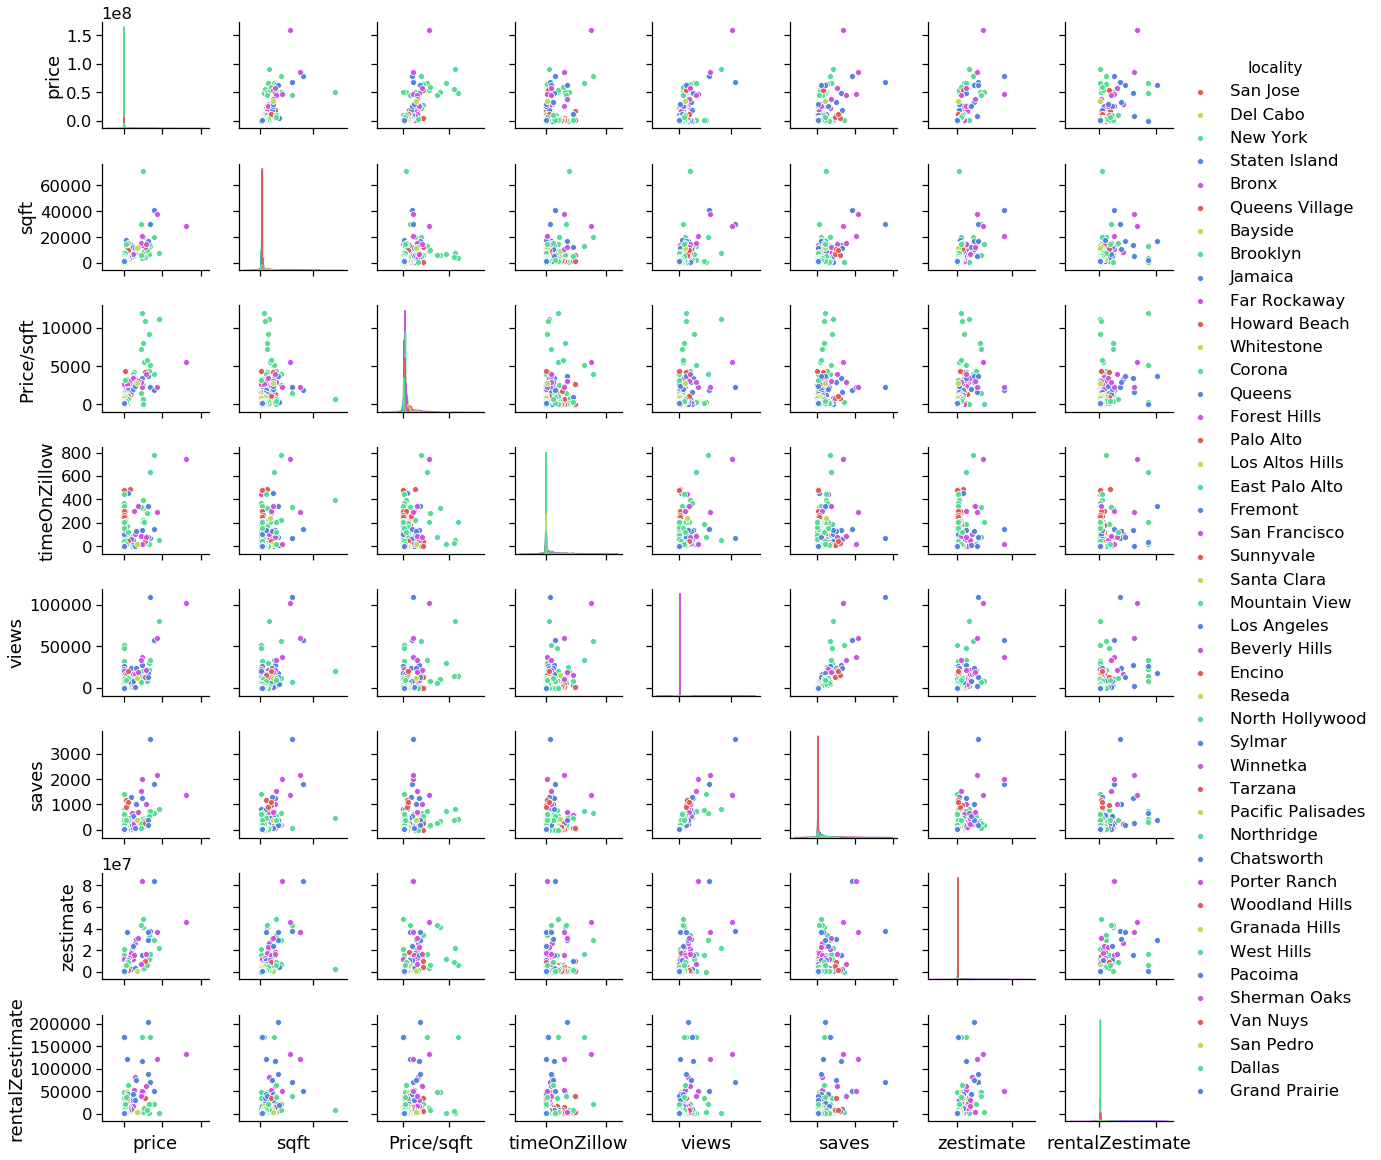

In [25]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns

# Pair plot to explore variables
with sns.plotting_context("notebook",font_scale=1.5):
    g = sns.pairplot(clean_df, vars = ['price','sqft','Price/sqft','timeOnZillow','views','saves','zestimate','rentalZestimate'], 
                 hue='locality',palette= sns.hls_palette(5),size=2)
g.set(xticklabels=[]);

## Import to CSV

In [26]:
clean_df.to_csv("After_Cleaning_1.csv",header = True)
print("Cleaned dataset is imported as After_Cleaning_1.csv file")
clean_df.shape

Cleaned dataset is imported as After_Cleaning_1.csv file


(855, 25)

After_Cleaning_1.csv file is the Preprocessed file which has 855 rows and 25 columns